# CENG403 - Spring 2024 - THE3

# Task 2: CNN with PyTorch
In this task, you will implement a convolutional neural network (CNN) with PyTorch.


## 2.1 Import the Modules

Let us start with importing some libraries that we will use throughout the task.

In [88]:
# PyTorch libraries:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import random
import torchinfo
from torchinfo import summary

# install and import the torchinfo library
#!pip install torchinfo


## 2.2 Enable GPU

First, under "Edit -> Notebook Settings -> Hardware accelerator", select a GPU. With the following, we will inform PyTorch that we want to use the GPU.

In [89]:
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is not available :(


## 2.3 The Dataset

We will use torchvision.datasets to download the CIFAR10 dataset.

In [90]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### 2.3.1 Visualize Samples

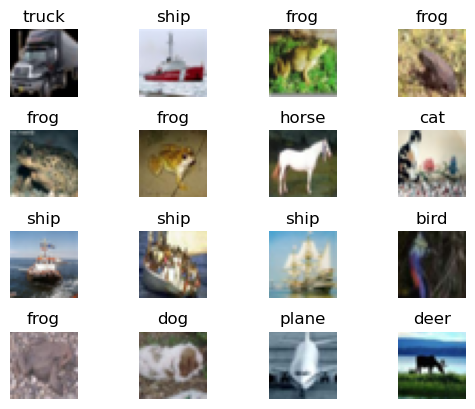

In [91]:
dataiter = iter(trainloader)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
S = 4

for i in range(S):
  for j in range(S):
    images, labels = next(dataiter)
    X = np.transpose(images[0].numpy()/2+0.5, (1, 2, 0))
    y = labels[0]

    plt.subplot(S, S, i*S+j+1)
    plt.imshow(X)
    plt.axis('off')
    plt.title(classes[y])
    plt.subplots_adjust(hspace = 0.5)

plt.show()

## 2.4 Define and Train a Small CNN Model

Now, all the pieces are ready and we can define a model.

### 2.4.1 Model Definition

Create a three-layer CNN with the following layers:

| Layer Name | Input HxW | Filter size | Stride | Pad | # of in channels | Out HxW | # of out channels |
| ----| -----| ----| ---| ---| ----| -----|---------- |
| Conv1   | 32x32 | ? | ? | ? | 3  | 28x28 | 16 |
| Conv2   | 28x28 | ? | ? | ? | 16 | 26x26 | 32 |
| Maxpool | 26x26 | 4 | 2 | 0 | 32 | 12x12 | 32 |
| Conv3   | 12x12 | ? | ? | ? | 32 | 10x10 | 32 |

and the fully-connected layers:

| Layer Name | Input Size | Output size |
| ----| -----| ----|
| FC1 | 3200 | 1500 |
| FC2 | 1500 | 10 |

You should choose suitable values for variables marked with `?' in the table and make sure that receptive fields can be properly placed in all layers.

While creating your model, pay attention to the following aspects:
* Each Conv layer and FC layer will be followed by ReLU, except for the last one.
* You should keep all other parameters (dilation, bias, group-mode, ..) as their default values in Pytorch.

You will need to read the following pages from Pytorch regarding the layers that you will use:
* [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
* [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html?highlight=maxpool#torch.nn.MaxPool2d)

In [92]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        torch.manual_seed(403)
        random.seed(403)
        np.random.seed(403)
        self.conv1 = None
        self.conv2 = None
        self.conv3 = None
        self.maxpool = None
        self.fc1 = None
        self.fc2 = None

        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=0)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=4, stride=2, padding=0)
        self.conv3 = torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.fc1 = torch.nn.Linear(3200, 1500)
        self.fc2 = torch.nn.Linear(1500, 10)

        
        ###########################################################
        # @TODO: Create the convolutional and FC layers as        #
        #  described above.                                       #
        ###########################################################

        ###########################################################
        #                         END OF YOUR CODE                #
        ###########################################################

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
      #######################################################
      # @TODO: Feedforward x through the layers. Note that x    #
      # needs to be reshaped to (batchsize, 3200) before        #
      # the FC layers.                                          #
      ###########################################################

      ###########################################################
      #                         END OF YOUR CODE                #
      ###########################################################
        return x

### 2.4.2 Trainer for the Model

Let us define our training function, which will use the cuda device for training the model.

In [93]:
def train(model, criterion, optimizer, epochs, dataloader, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the loss history.
  """
  loss_history = []
  for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):

      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs = model(inputs)

      # Calculate loss
      loss = criterion(outputs.to(device), labels)

      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      loss_history.append(loss.item())

    if verbose: print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

  return loss_history

### 2.4.3 Create and visualize the model

In [94]:
model = SmallCNN()


summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
SmallCNN                                 [128, 10]                 --
├─Conv2d: 1-1                            [128, 16, 28, 28]         1,216
├─Conv2d: 1-2                            [128, 32, 26, 26]         4,640
├─MaxPool2d: 1-3                         [128, 32, 12, 12]         --
├─Conv2d: 1-4                            [128, 32, 10, 10]         9,248
├─Linear: 1-5                            [128, 1500]               4,801,500
├─Linear: 1-6                            [128, 10]                 15,010
Total params: 4,831,614
Trainable params: 4,831,614
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.26
Input size (MB): 1.57
Forward/backward pass size (MB): 39.82
Params size (MB): 19.33
Estimated Total Size (MB): 60.72

### 2.4.4 Train the Small Model

We will create an instance of our model and "define" which loss function we want to use. We will also state our choice for the optimizer here.

For more information, check the PyTorch docs: [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) and [SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD).

In [95]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)
epochs = 10
loss_history = train(model, criterion, optimizer, epochs, trainloader)

KeyboardInterrupt: 

### 2.4.5 The Loss Curve

Let us visualize the loss curve.

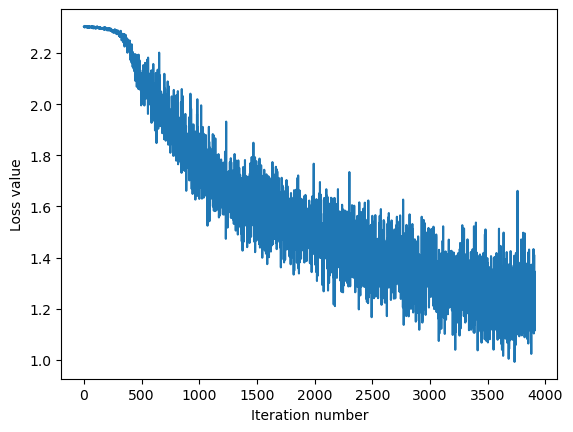

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 2.4.6 Quantitative Analysis

We can analyze the accuracy of the predictions as follows. You should see around 54\% accuracies. We can finetune the hyperparameters to obtain better results. But we will skip that and go for a bigger model.

*Disclaimer: This code piece is taken from PyTorch examples.*

In [ ]:
correct = 0
total = 0
model = model.to("cpu")
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

RuntimeError: The size of tensor a (32) must match the size of tensor b (128) at non-singleton dimension 2

## 2.5 Your CNN

Now, create your own CNN. It should have at least 5 convolutional layers. Other than that, there is no restriction on what you can use in your CNN or how you can structure it.


### 2.5.1 Model Definition

In [103]:
import torch.nn as nn
import torch.nn.functional as F

class YourCNN(nn.Module):
    def __init__(self):
        super(YourCNN, self).__init__()
        torch.manual_seed(403)
        random.seed(403)
        np.random.seed(403)

        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv5 = torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(256*8*8, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.fc3 = torch.nn.Linear(256, 10)
        ###########################################################
        # @TODO: Create your layers here.                         #
        ###########################################################
        ###########################################################
        #                         END OF YOUR CODE                #
        ###########################################################

    def forward(self, x):
      ###########################################################
      # @TODO: Feedforward x through the layers.                #
      ###########################################################
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool2(x)
        x = F.relu(self.conv5(x))
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No ReLU activation here
        return x
      ###########################################################
      #                         END OF YOUR CODE                #
      ###########################################################

### 2.5.2 Create and visuale your model

In [104]:
model = YourCNN()

summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
YourCNN                                  [128, 10]                 --
├─Conv2d: 1-1                            [128, 16, 32, 32]         448
├─Conv2d: 1-2                            [128, 32, 32, 32]         4,640
├─MaxPool2d: 1-3                         [128, 32, 16, 16]         --
├─Conv2d: 1-4                            [128, 64, 16, 16]         18,496
├─Conv2d: 1-5                            [128, 128, 16, 16]        73,856
├─MaxPool2d: 1-6                         [128, 128, 8, 8]          --
├─Conv2d: 1-7                            [128, 256, 8, 8]          295,168
├─Linear: 1-8                            [128, 512]                8,389,120
├─Linear: 1-9                            [128, 256]                131,328
├─Linear: 1-10                           [128, 10]                 2,570
Total params: 8,915,626
Trainable params: 8,915,626
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 7.20
Input s

### 2.5.3 Train the Model

In [105]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)
epochs = 10
loss_history = train(model, criterion, optimizer, epochs, trainloader)

Epoch 0 / 10: avg. loss of last 5 iterations 2.3050991535186767
Epoch 1 / 10: avg. loss of last 5 iterations 2.3021515369415284
Epoch 2 / 10: avg. loss of last 5 iterations 2.3009617805480955
Epoch 3 / 10: avg. loss of last 5 iterations 2.299912214279175
Epoch 4 / 10: avg. loss of last 5 iterations 2.2950408935546873
Epoch 5 / 10: avg. loss of last 5 iterations 2.247488498687744
Epoch 6 / 10: avg. loss of last 5 iterations 2.0590041875839233
Epoch 7 / 10: avg. loss of last 5 iterations 1.8581740140914917
Epoch 8 / 10: avg. loss of last 5 iterations 1.7623431444168092
Epoch 9 / 10: avg. loss of last 5 iterations 1.6591366529464722


### 2.5.4 Loss Curve

Let us visualize the loss curve.

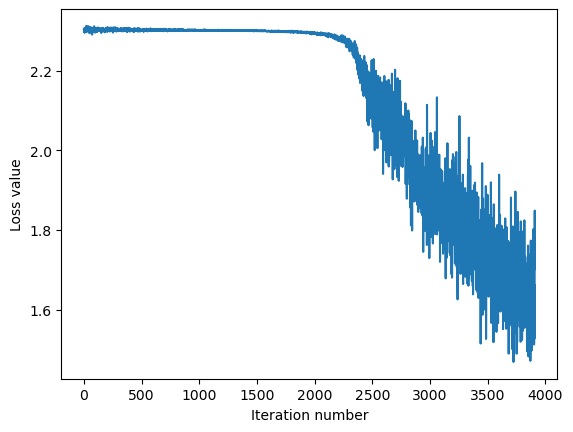

In [106]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 2.5.5 Quantitative Analysis

Analyze your model quantitatively.

*Disclaimer: This code piece is taken from PyTorch examples.*

In [107]:
correct = 0
total = 0
model = model.to("cpu")
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 41 %
